There should be an appropriate count of valid surface types within each grid cell in order to calculate sea ice concentration from CS2. In this code, we therefore check the validity of the CS2 surface detection within each grid cell. We take the gridded CS2 along-track data for each month, and plot the count of different valid surfaces returns seasonally across the CAA.

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import glob
import pandas as pd
import os
import cartopy
import cartopy.crs as ccrs
import scipy
from scipy import stats

In [8]:
# Define a function for plotting the surface counts on maps on a grid

def plotting_maps_grid(map_projection, new_x, new_y, data,vmin, vmax, cmap, ax=None):
    if ax is None:
        fig, ax = plt.subplots(subplot_kw={'projection': map_projection})
    else:
        fig = ax.figure
    
    ax.coastlines(linewidth=0.2,zorder=2)
    ax.set_extent([x_min, x_max, y_min, y_max], crs=map_projection)
    ax.add_feature(cartopy.feature.LAND, color='gainsboro', zorder=1)
    pcm = ax.pcolormesh(new_x, new_y, data, cmap=cmap, transform=map_projection, vmin=vmin, vmax=vmax,zorder=0)
    
    return pcm


def transform_coords(lon, lat, projection):
    x, y = projection.transform_point(lon, lat, ccrs.PlateCarree())
    return x, y


Edge grid shape =  (59, 132)


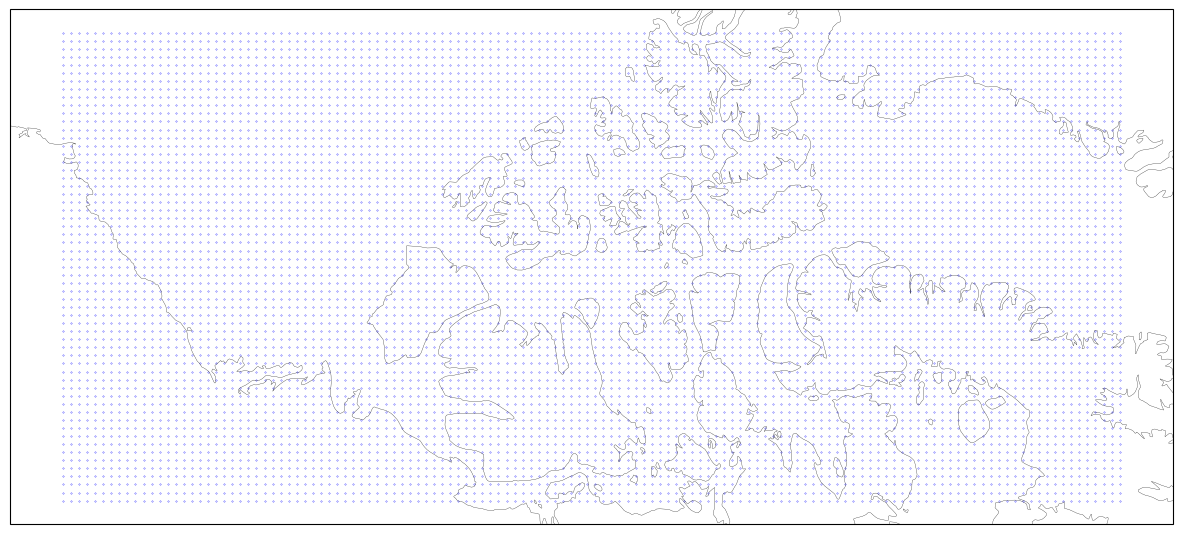

In [3]:
# Create the grid that the data are mapped on over the CAA

# Define the custom Lambert Azimuthal Equal Area projection
map_projection = ccrs.LambertAzimuthalEqualArea(central_longitude=-105,central_latitude=74)

# Coordinates to transform (lon, lat) in the Plate Carree projection
geo_extent = [-140, -70, 64, 79]

# Get corners of 'bounding box' from geo_extent
corners = [
    (geo_extent[0], geo_extent[2]),  # SW corner
    (geo_extent[1], geo_extent[2]),  # SE corner
    (geo_extent[0], geo_extent[3]),  # NW corner
    (geo_extent[1], geo_extent[3])   # NE corner
]

# Transform coordinates to the desired map area
proj_corners = [transform_coords(lon, lat, map_projection) for lon, lat in corners]
x_coords, y_coords = zip(*proj_corners)

x_min, x_max = min(x_coords), max(x_coords)
y_min, y_max = min(y_coords), max(y_coords)

grid_spacing = 25000 # 25 km

x_grid_edge = np.arange(x_min-grid_spacing,x_max + grid_spacing, grid_spacing)
y_grid_edge = np.arange(y_min-grid_spacing,y_max + grid_spacing, grid_spacing)
new_x_edge, new_y_edge= np.meshgrid(x_grid_edge, y_grid_edge) # For CS2 data

print('Edge grid shape = ',np.shape(new_x_edge)) 

# Set up the figure
fig = plt.figure(figsize=(15, 20))
ax = plt.axes(projection=map_projection)
ax.coastlines(linewidth=0.2)
ax.scatter(new_x_edge,new_y_edge,0.05, color='blue')
plt.show()

In [6]:
months = ['10','11','12','01','02','03','04','05']

# Locate directories
source_directory = ('/Users/amyswiggs/Desktop/Autumn2023/Chapter2/Northumbria_Spring_Data/NWP_CS2_Grids/NWP_CS2_Regrid/')

# Create dictionaries to hold data for all months
floes_all_months = {}
leads_all_months = {}
ocean_all_months = {}

# Read in number of floes, leads, and ocean waveforms with bias adjustment applied
# These are the counts of each surface type within each 25 x 25 km grid cell
for month in months:
    floes,leads,ocean = [],[],[]
    for year in range(2011,2024):
        count_floes = np.load(source_directory+str(year)+str(month)+'_CountFloesRegrid.npy') 
        count_leads = np.load(source_directory+str(year)+str(month)+'_CountLeadsRegrid.npy')
        count_ocean = np.load(source_directory+str(year)+str(month)+'_CountOceanRegrid.npy')

        floes.append(count_floes)
        leads.append(count_leads)
        ocean.append(count_ocean)
    
    floes_all_months[month] = np.nanmean(np.stack(floes, axis=0), axis=0)
    leads_all_months[month] = np.nanmean(np.stack(leads, axis=0), axis=0)
    ocean_all_months[month] = np.nanmean(np.stack(ocean, axis=0), axis=0)



/var/folders/q1/prwbhm6j6x1gcchb7r0p2kyh0000gn/T/ipykernel_59541/998959482.py:24: RuntimeWarning: Mean of empty slice
  floes_all_months[month] = np.nanmean(np.stack(floes, axis=0), axis=0)
/var/folders/q1/prwbhm6j6x1gcchb7r0p2kyh0000gn/T/ipykernel_59541/998959482.py:25: RuntimeWarning: Mean of empty slice
  leads_all_months[month] = np.nanmean(np.stack(leads, axis=0), axis=0)
/var/folders/q1/prwbhm6j6x1gcchb7r0p2kyh0000gn/T/ipykernel_59541/998959482.py:26: RuntimeWarning: Mean of empty slice
  ocean_all_months[month] = np.nanmean(np.stack(ocean, axis=0), axis=0)


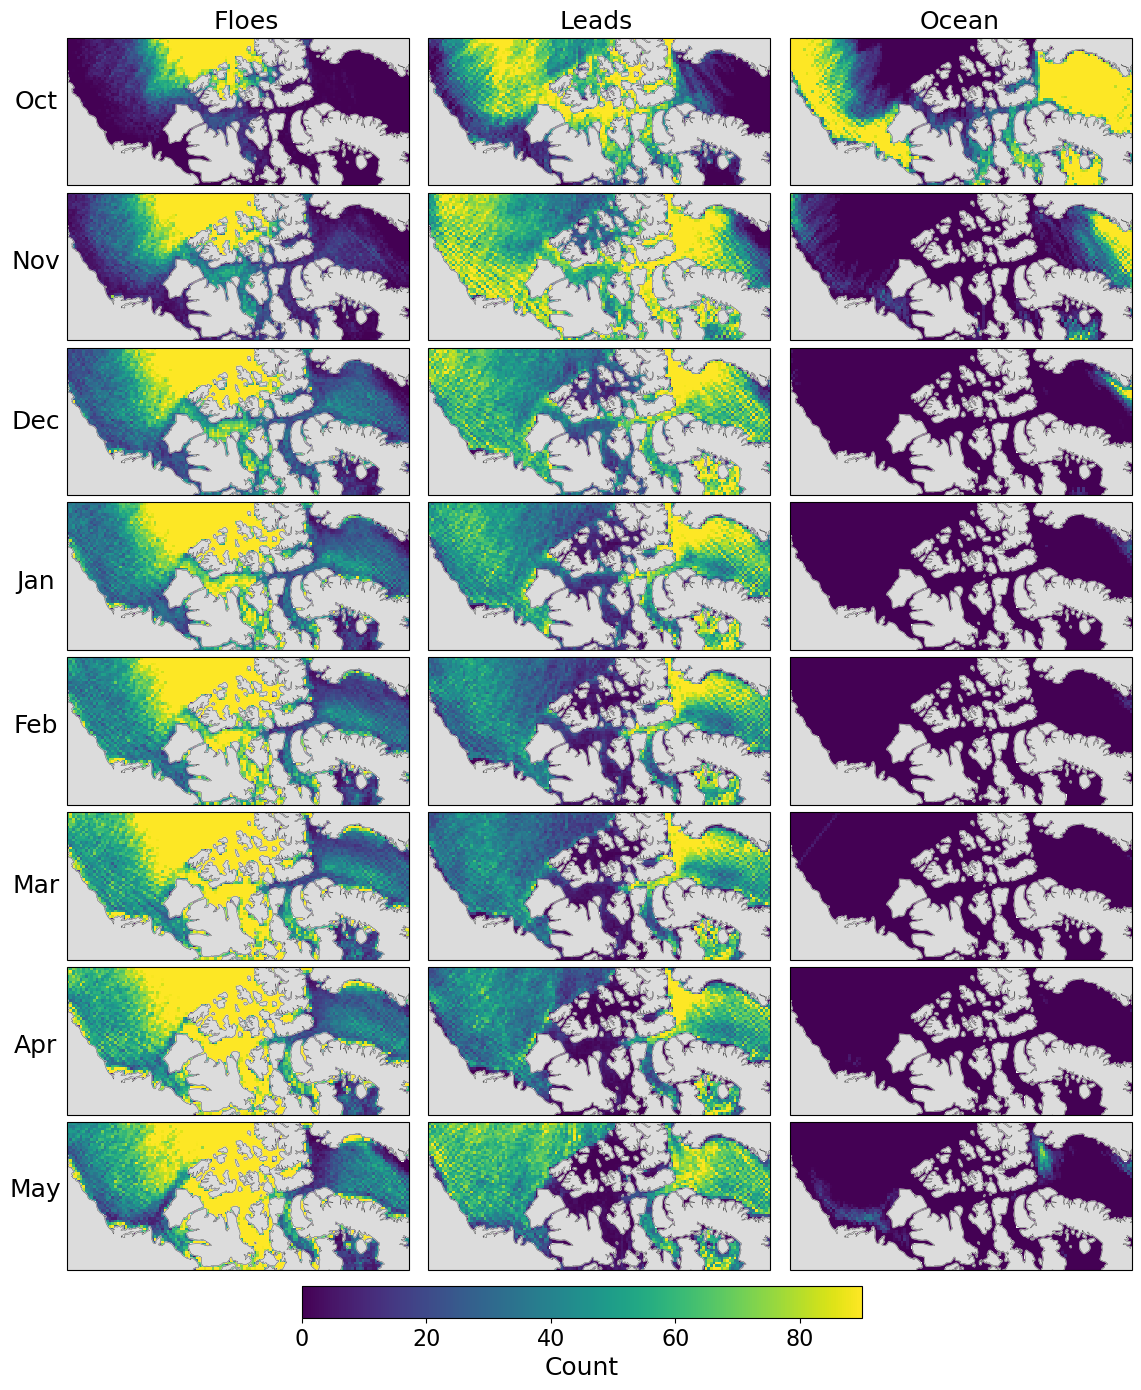

In [9]:
# Plot the figure

fig_a, axs_a = plt.subplots(8, 3, figsize=(14,16), subplot_kw={'projection':map_projection})

for i, month in enumerate(months):
    # Plot Floes
    plotting_maps_grid(map_projection, new_x_edge, new_y_edge, floes_all_months[month],
                           vmin=0, vmax=90, cmap='viridis', ax=axs_a[i, 0])

    # Plot Leads
    pcm = plotting_maps_grid(map_projection, new_x_edge, new_y_edge, leads_all_months[month],
                           vmin=0, vmax=90, cmap='viridis', ax=axs_a[i, 1])

    # Plot Ocean
    plotting_maps_grid(map_projection, new_x_edge, new_y_edge, ocean_all_months[month],
                           vmin=0, vmax=90, cmap='viridis', ax=axs_a[i, 2])

plt.subplots_adjust(wspace=0, hspace=0.05)


fig_a.text(0.11, 0.84, 'Oct', va='center', ha='center', 
         rotation='horizontal', fontsize=18, transform=fig_a.transFigure)
fig_a.text(0.11, 0.74, 'Nov', va='center', ha='center', 
         rotation='horizontal', fontsize=18, transform=fig_a.transFigure)
fig_a.text(0.11, 0.64, 'Dec', va='center', ha='center', 
         rotation='horizontal', fontsize=18, transform=fig_a.transFigure)
fig_a.text(0.11, 0.54, 'Jan', va='center', ha='center', 
         rotation='horizontal', fontsize=18, transform=fig_a.transFigure)
fig_a.text(0.11, 0.45, 'Feb', va='center', ha='center', 
         rotation='horizontal', fontsize=18, transform=fig_a.transFigure)
fig_a.text(0.11, 0.35, 'Mar', va='center', ha='center', 
         rotation='horizontal', fontsize=18, transform=fig_a.transFigure)
fig_a.text(0.11, 0.25, 'Apr', va='center', ha='center', 
         rotation='horizontal', fontsize=18, transform=fig_a.transFigure)
fig_a.text(0.11, 0.16, 'May', va='center', ha='center', 
         rotation='horizontal', fontsize=18, transform=fig_a.transFigure)


fig_a.text(0.26, 0.89, 'Floes', va='center', ha='center', 
         rotation='horizontal', fontsize=18, transform=fig_a.transFigure)
fig_a.text(0.51,0.89, 'Leads', va='center', ha='center', 
         rotation='horizontal', fontsize=18, transform=fig_a.transFigure)
fig_a.text(0.77, 0.89, 'Ocean', va='center', ha='center', 
         rotation='horizontal', fontsize=18, transform=fig_a.transFigure)

# Plot colorbar underneath axis
cbar_ax = fig_a.add_axes([0.3, 0.08, 0.4, 0.02]) # left bottom width height
cbar = fig_a.colorbar(pcm, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Count', fontsize=18)

fig_a.savefig('/Users/amyswiggs/Desktop/Autumn2023/Chapter2/Northumbria_Spring_Data/NWP_SIC_Plots/ReSubmission_Plots/Fig02_SurfaceTypes.png',dpi=300,bbox_inches="tight")


In [4]:
autumn = ['10','11']
winter = ['12','01']
early_spring = ['02','03']
late_spring = ['04','05']

# Define seasons
seasons = {'Autumn': autumn, 'Winter': winter, 'Early-Spring': early_spring, 'Late-Spring': late_spring}

# Locate directories
source_directory = ('/Users/amyswiggs/Desktop/Autumn2023/Chapter2/Northumbria_Spring_Data/NWP_CS2_Grids/NWP_CS2_Regrid/')
#source_directory = ('.../CS2_grids/')

# Create dictionaries to hold data for all seasons
floes_all_seasons = {}
leads_all_seasons = {}
ocean_all_seasons = {}

# Read in number of floes, leads, and ocean waveforms with bias adjustment applied
# These are the counts of each surface type within each 25 x 25 km grid cell
for season_name, season_data in seasons.items():
    floes,leads,ocean = [],[],[]
    for year in range(2011,2024):
        for month in season_data:
            count_floes = np.load(source_directory+str(year)+str(month)+'_CountFloesRegrid.npy') 
            count_leads = np.load(source_directory+str(year)+str(month)+'_CountLeadsRegrid.npy')
            count_ocean = np.load(source_directory+str(year)+str(month)+'_CountOceanRegrid.npy')

            floes.append(count_floes)
            leads.append(count_leads)
            ocean.append(count_ocean)
    
    floes_all_seasons[season_name] = np.nanmean(np.stack(floes, axis=0), axis=0)
    leads_all_seasons[season_name] = np.nanmean(np.stack(leads, axis=0), axis=0)
    ocean_all_seasons[season_name] = np.nanmean(np.stack(ocean, axis=0), axis=0)



/var/folders/q1/prwbhm6j6x1gcchb7r0p2kyh0000gn/T/ipykernel_95358/2025691242.py:32: RuntimeWarning: Mean of empty slice
  floes_all_seasons[season_name] = np.nanmean(np.stack(floes, axis=0), axis=0)
/var/folders/q1/prwbhm6j6x1gcchb7r0p2kyh0000gn/T/ipykernel_95358/2025691242.py:33: RuntimeWarning: Mean of empty slice
  leads_all_seasons[season_name] = np.nanmean(np.stack(leads, axis=0), axis=0)
/var/folders/q1/prwbhm6j6x1gcchb7r0p2kyh0000gn/T/ipykernel_95358/2025691242.py:34: RuntimeWarning: Mean of empty slice
  ocean_all_seasons[season_name] = np.nanmean(np.stack(ocean, axis=0), axis=0)


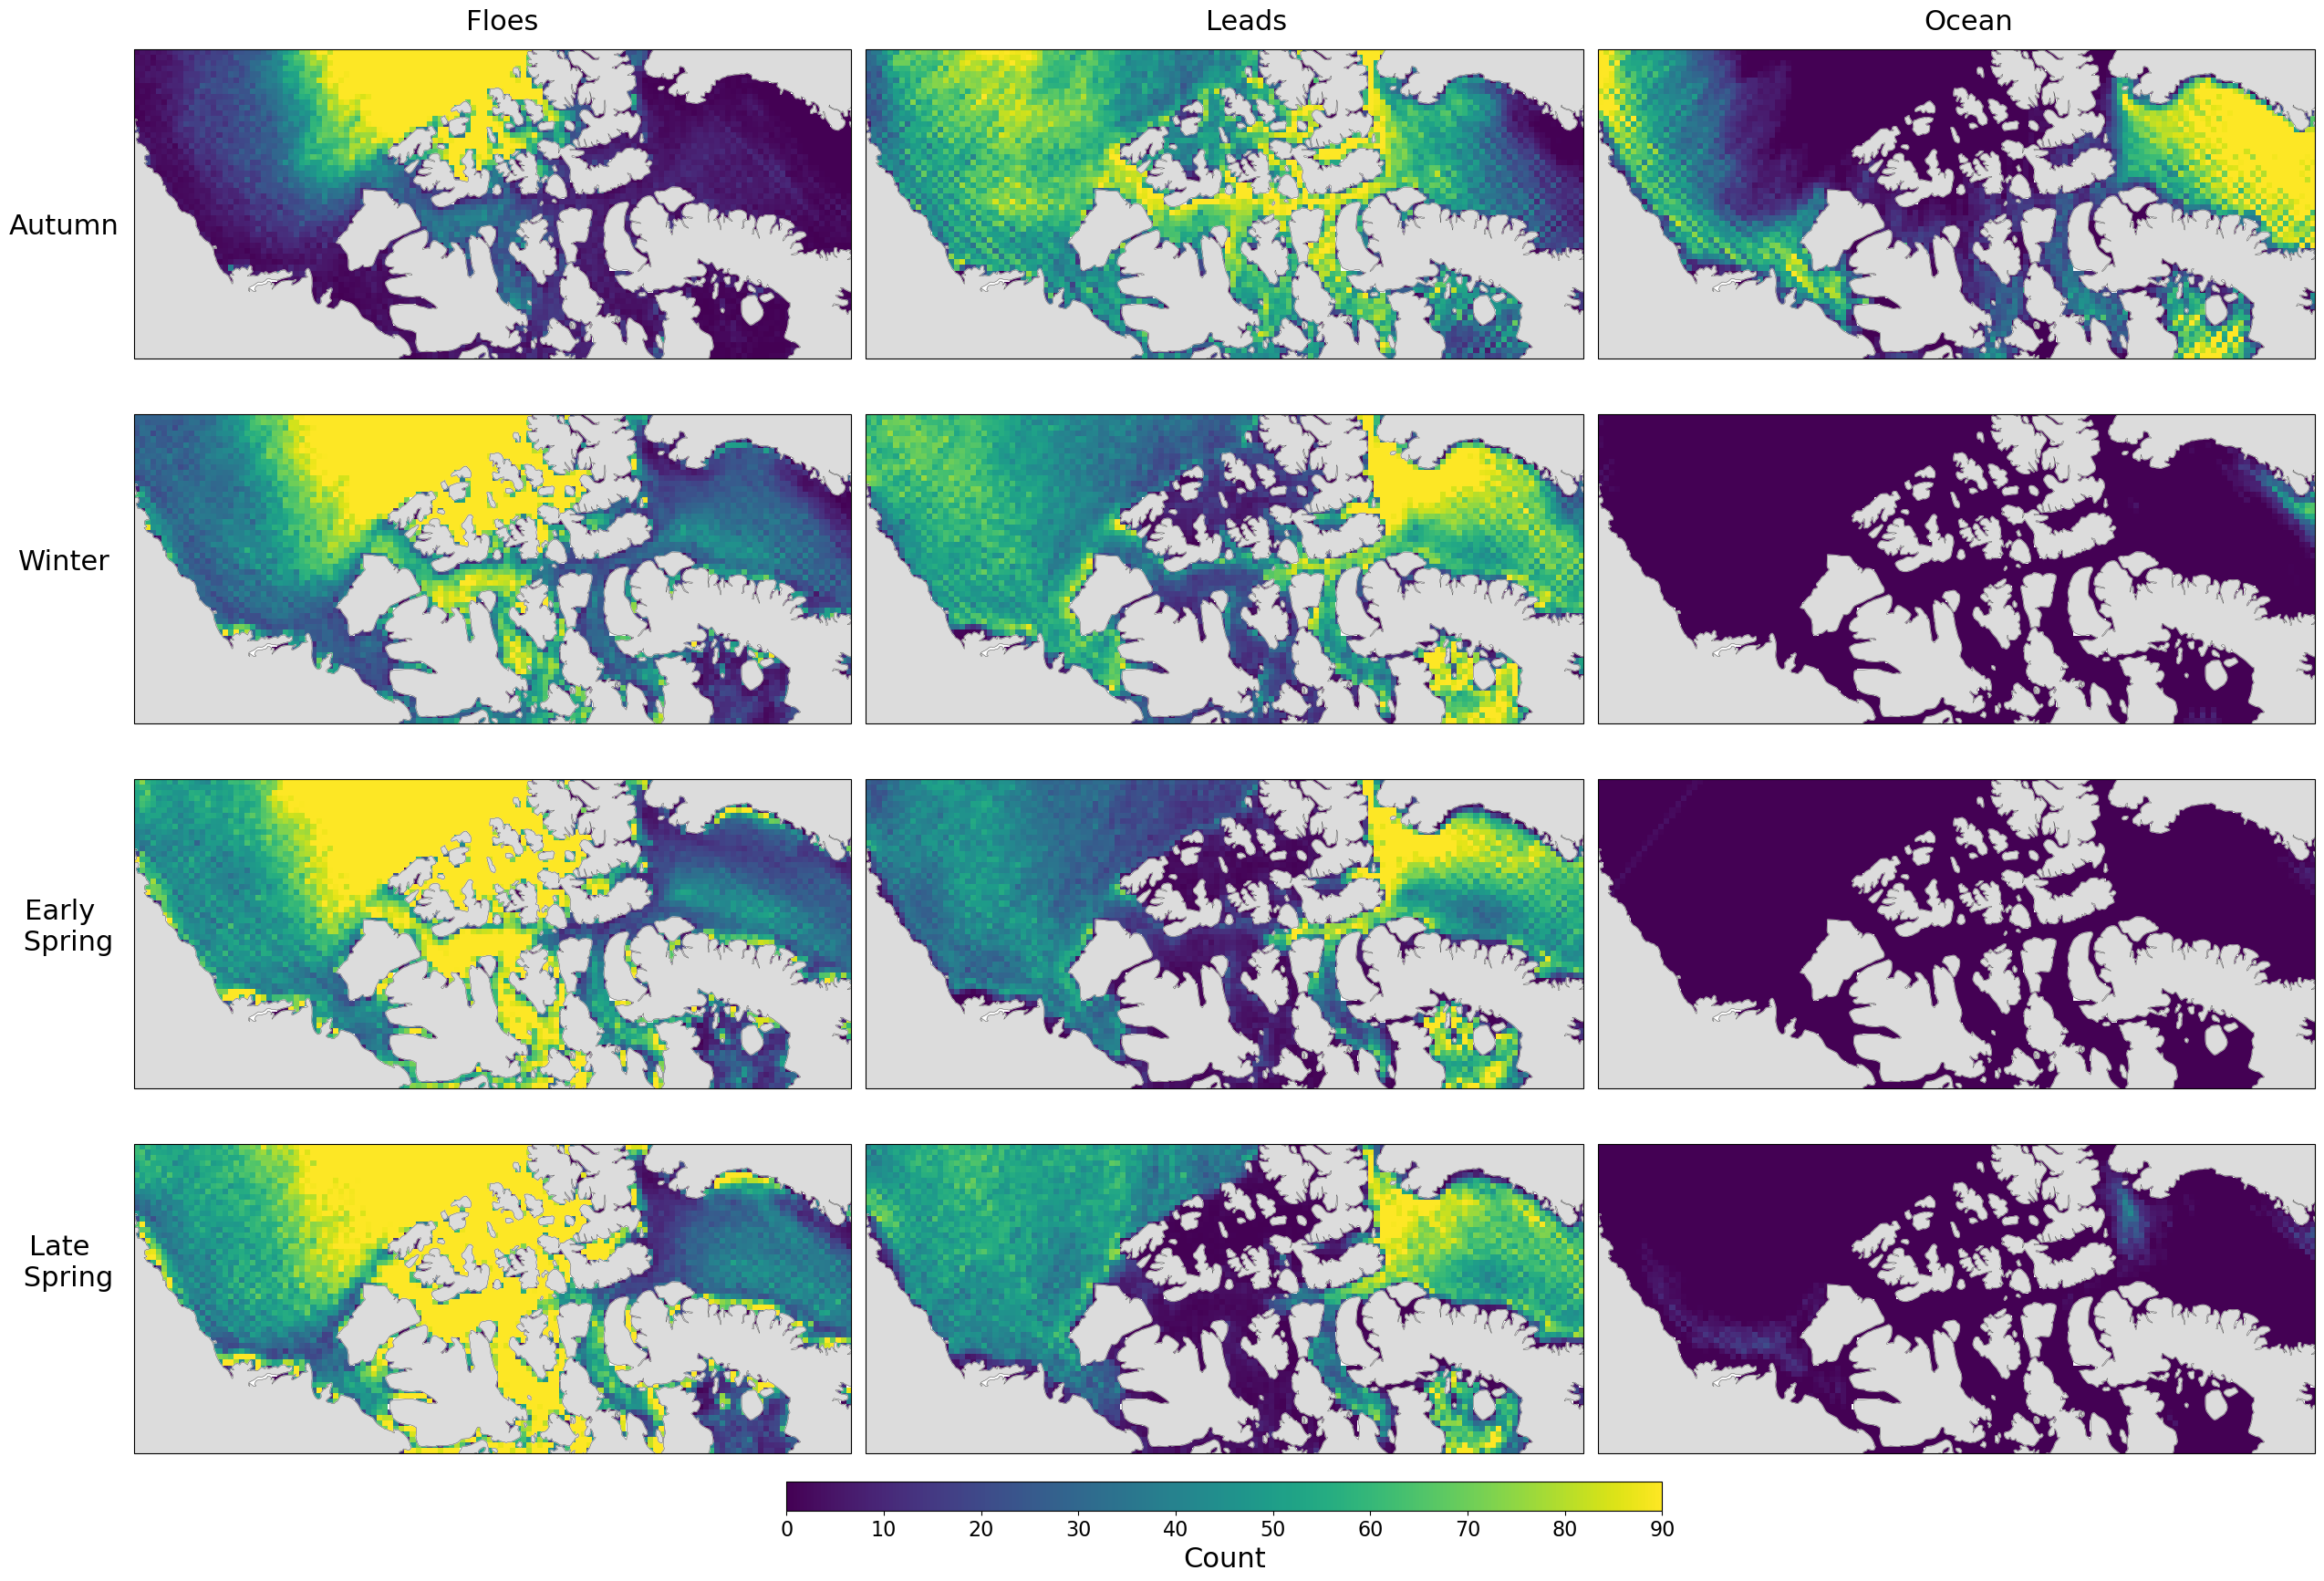

In [5]:
# Plot the figure

fig, axs = plt.subplots(4, 3, figsize=(24,16), subplot_kw={'projection':map_projection}, layout='constrained')

for i, season_name in enumerate(seasons.keys()):
    # Plot Floes
    plotting_maps_grid(map_projection, new_x_edge, new_y_edge, floes_all_seasons[season_name],
                  'Count', 'Floes ' + season_name, 0, 90, 'viridis', axs[i, 0])

    # Plot Leads
    pcm = plotting_maps_grid(map_projection, new_x_edge, new_y_edge, leads_all_seasons[season_name],
                  'Count', 'Leads ' + season_name, 0, 90, 'viridis', ax=axs[i, 1])

    # Plot Ocean
    plotting_maps_grid(map_projection, new_x_edge, new_y_edge, ocean_all_seasons[season_name],
                  'Count', 'Ocean ' + season_name, 0, 90, 'viridis', ax=axs[i, 2])

# Add labels
fig.text(-0.03, 0.86, 'Autumn', va='center', ha='center', 
         rotation='horizontal', fontsize=22, transform=fig.transFigure)
fig.text(-0.03, 0.63, 'Winter', va='center', ha='center', 
         rotation='horizontal', fontsize=22, transform=fig.transFigure)
fig.text(-0.03, 0.38, 'Early \n Spring', va='center', ha='center', 
         rotation='horizontal', fontsize=22, transform=fig.transFigure)
fig.text(-0.03, 0.15, 'Late \n Spring', va='center', ha='center', 
         rotation='horizontal', fontsize=22, transform=fig.transFigure)

fig.text(0.17, 1, 'Floes', va='center', ha='center', 
         rotation='horizontal', fontsize=22, transform=fig.transFigure)
fig.text(0.51, 1, 'Leads', va='center', ha='center', 
         rotation='horizontal', fontsize=22, transform=fig.transFigure)
fig.text(0.84, 1, 'Ocean', va='center', ha='center', 
         rotation='horizontal', fontsize=22, transform=fig.transFigure)

# Plot colorbar underneath axis
cbar_ax = fig.add_axes([0.3, -0.02, 0.4, 0.02])
cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Count', fontsize=22)

plt.show()

fig.savefig('/Users/amyswiggs/Desktop/Autumn2023/Chapter2/Northumbria_Spring_Data/NWP_SIC_Plots/Submission_Plots/Fig02.png',dpi=400,bbox_inches="tight")


